# PoliDuckies
A notebook with the complete pipeline

### Standard imports

In [1]:
execution = 'local' #@param ['local', 'colab']

In [32]:
import os 
branch = "daffy" #@param ['master', 'daffy']

if not os.path.isdir('gym-duckietown') and not os.path.isdir('../gym-duckietown'):
  !git clone --branch {branch} https://github.com/duckietown/gym-duckietown.git
  !pip3 install -e gym-duckietown
if "/gym-duckietown" not in os.getcwd():
  os.chdir('gym-duckietown')
  
!pip install numpy
!apt install xvfb -y
!pip3 install pyvirtualdisplay
!pip install pyglet==1.5.14
!pip install duckietown-gym-daffy
!pip install poliduckie-segmentation

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.3-2ubuntu2.9).
0 upgraded, 0 newly installed, 0 to remove and 92 not upgraded.


In [35]:
!pwd

/mnt/c/Polimi/2ndYear/DuckieTown/poliduckie_pipeline/notebooks/gym-duckietown


In [4]:
from pyvirtualdisplay import Display
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
%matplotlib inline

## used to copy the model to the gdrive folder
import shutil

import cv2
import gym
import gym_duckietown
import pyglet

# Gym has a built in logger to log information. The information is split in importance levels, from highest to lowest:
# CRITICAL, ERROR, WARNING, INFO, DEBUG, NOTSET
# To stop gym from printing many verbose NOTSET, INFO and DEBUG messages we let it print only level WARNING or higher messages
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

DEBUG:commons:version: 6.2.4 *
DEBUG:typing:version: 6.2.3
DEBUG:duckietown_world:duckietown-world version 6.4.3 path /usr/local/lib/python3.9/dist-packages
DEBUG:geometry:PyGeometry-z6 version 2.1.4 path /usr/local/lib/python3.9/dist-packages
DEBUG:aido_schemas:aido-protocols version 6.1.1 path /usr/local/lib/python3.9/dist-packages
DEBUG:nodes:version 6.2.17 path /usr/local/lib/python3.9/dist-packages pyparsing 2.4.7
DEBUG:gym-duckietown:gym-duckietown version 6.1.34 path /usr/local/lib/python3.9/dist-packages



{'audio': ('xaudio2', 'directsound', 'openal', 'pulse', 'silent'), 'debug_font': False, 'debug_gl': True, 'debug_gl_trace': False, 'debug_gl_trace_args': False, 'debug_graphics_batch': False, 'debug_lib': False, 'debug_media': False, 'debug_texture': False, 'debug_trace': False, 'debug_trace_args': False, 'debug_trace_depth': 1, 'debug_trace_flush': True, 'debug_win32': False, 'debug_x11': False, 'graphics_vbo': True, 'shadow_window': True, 'vsync': None, 'xsync': True, 'xlib_fullscreen_override_redirect': False, 'darwin_cocoa': True, 'search_local_libs': True}


In [5]:
map_name = "Duckietown-small_loop-v0"

### Methods

In [6]:
from poliduckie_segmentation.segmentation import Segmentation

seg = Segmentation()

def segmentation(image):
  """
    Returns the image from the simulation with the segmentation

    Image: np.Array
    ------
    Image: np.Array
  """
  resized = cv2.resize(image, (320, 240))
  return seg.predict(resized)

2023-04-07 20:01:52.514062: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-07 20:01:52.591950: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-07 20:01:52.921898: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-07 20:01:52.923100: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 20:01:54.477919: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 240, 320, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 240, 320, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [7]:
if execution == 'colab':
    !wget https://github.com/poliduckie/poliduckie_pipeline/blob/SingleFixedDistanceReference/notebooks/BirdEyeMatrices/SegmentationOutput.pkl?raw=true
    !mv SegmentationOutput.pkl?raw=true SegmentationOutput.pkl

In [28]:
from poliduckie_segmentation import BirdEyeView

matrixPath = './SegmentationOutput.pkl' if execution == 'colab' else './/SegmentationOutput.pkl'

birdeye = BirdEyeView(path = matrixPath)

def birdEyeTransform(image):
  """
    Returns the image from the simulation with the bird eye view

    Image: np.Array
    ------
    Image: np.Array
  """
  return birdeye.computeBirdEye(image)

FileNotFoundError: [Errno 2] No such file or directory: './SegmentationOutput.pkl'

In [7]:
from poliduckie_segmentation.line_extraction import LineExtraction

lineExtraction_ = LineExtraction()
lineExtraction_.N_CLUSTERS = 5
lineExtraction_.MIN_ENTRIES = 8
lineExtraction_.MAX_DISTANCE = 10

def lineExtraction(image, n_points=100, mode="bezier", bezier_degree=3):
  """
    Returns the central line extracted as a numpy array. The mode can be either "bezier" or "spline"

    Image: np.Array
    n_points: int
    mode: str
    bezier_degree: int
    ------
    Line: np.Array
  """
  if mode == "bezier":
    bezier_points = lineExtraction_.bezier_fit(image, degree=bezier_degree, nPoints=n_points)
    return bezier_points
  
  elif mode == "spline":
    spline_points = lineExtraction_.spline_interpolation(image, nPoints=n_points)
    return spline_points

In [8]:
METER_PER_PIXEL = 0.4 / 150
CAR_POSITION = [320/2, 240]

def computeReference(line, N, vertical_cutoff, img_size_y):
  """
    Returns the references in meters
    Reference is a list with dimension (2, N)
    N is the prediction horizon of the MPC

    Line: np.Array
    N: int
    ------
    reference: List[[List[Float], List[Float]]]
  """
  reference = line[:, :N]

  #center around car position
  reference[0] = [x - CAR_POSITION[0] for x in reference[0]]
  reference[1] = [img_size_y - vertical_cutoff - (y - CAR_POSITION[1]) for y in reference[1]]

  #convert to meters
  reference[0] = [x * METER_PER_PIXEL for x in reference[0]]
  reference[1] = [y * METER_PER_PIXEL for y in reference[1]]
  
  return reference

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
from poliduckie_segmentation.control import MPC
N = 10
M = MPC(N=10)

def runMpc(state, reference):
  """
    Returns the control inputs to give to the car.
    State is [x, y, theta, v, w]
    Reference is a list with dimension (2, N)

    state: [Float, Float, Float, Float, Float]
    reference: List[[List[Float], List[Float]]]
    ------
    u: List[Float, Float]
  """
  return M.mpc(state, reference)

In [10]:
imageVisualization = 'Plt' #@param ['Plt', 'CV2']

def plt_imshow(image):
  plt.imshow(image)
  plt.show()


if imageVisualization == 'CV2':
  from google.colab.patches import cv2_imshow
  imshow = cv2_imshow
else:
  imshow = plt_imshow

### Simulation

INFO:duckietown_world: data: /usr/local/lib/python3.9/dist-packages/duckietown_world/data
/usr/local/lib/python3.9/dist-packages/gym/utils/seeding.py:63: DeprecationWarning: WARN: Function `rng.randint(low, [high, size, dtype])` is marked as deprecated and will be removed in the future. Please use `rng.integers(low, [high, size, dtype])` instead.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step AP

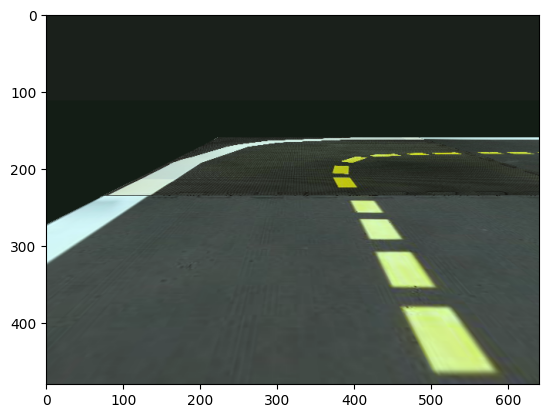

In [11]:
display = Display(visible=0, size=(1400, 900))
display.start()
window = pyglet.window.Window()
env = gym.make(map_name)
env.unwrapped.user_tile_start = [0,1]
env.unwrapped.start_pose = [[0.21699990272521976, 0, 0.41029359288296474], np.pi/2]
imshow(env.reset())

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/utils/passive_env_checker.py:280: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


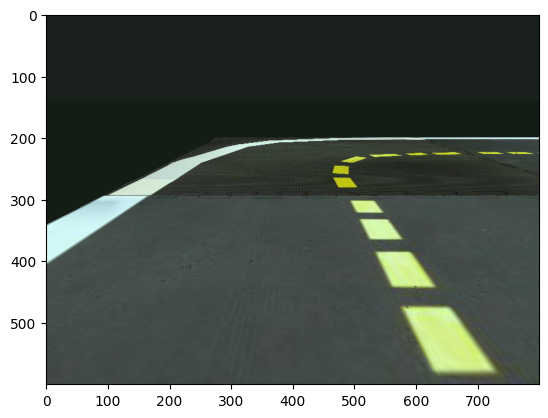

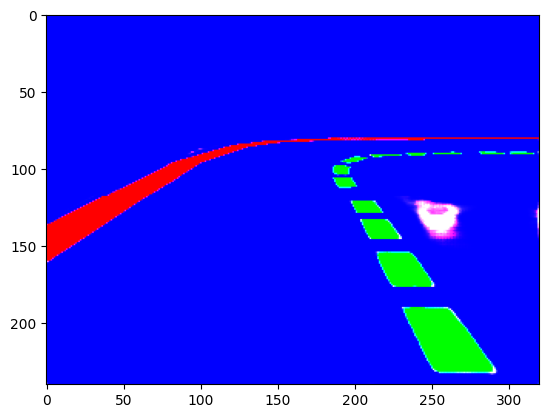

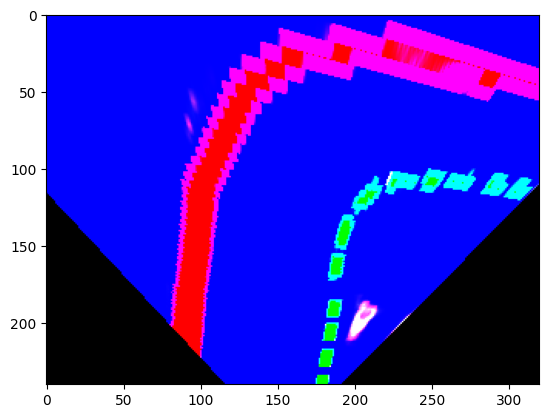

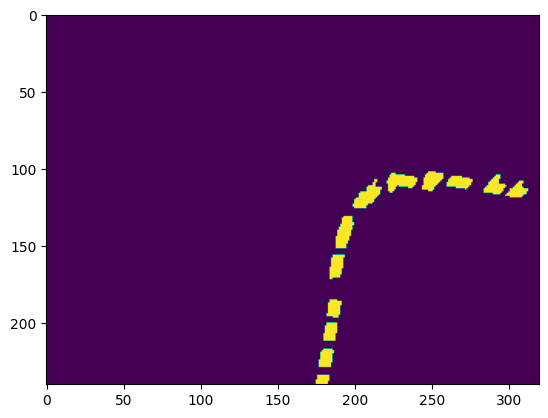

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f068bf041f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/threadpoolctl.py", line 584, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.9/dist-packages/threadpoolctl.py", line 725, in _make_controller_from_path
    lib_controller = lib_controller_class(
  File "/usr/local/lib/python3.9/dist-packages/threadpoolctl.py", line 842, in __init__
    super().__init__(**kwargs)
  File "/usr/local/lib/python3.9/dist-packages/threadpoolctl.py", line 810, in __init__
    self._dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOL

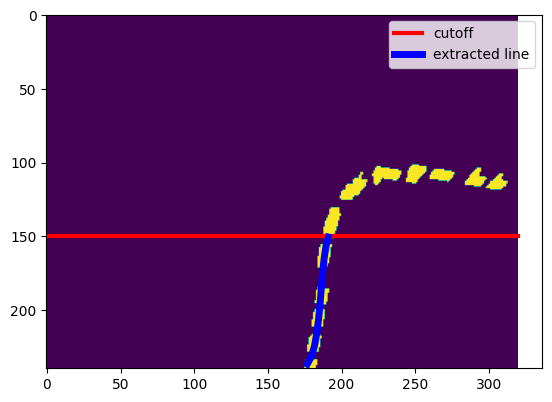

[[0.04457143 0.05187752 0.05751783 0.06182566 0.06513427 0.06777697
  0.07008703 0.07239775 0.0750424  0.07835428 0.08266667]
 [0.6487619  0.66237722 0.68152395 0.70490908 0.73123959 0.75922247
  0.78756469 0.81497324 0.84015509 0.86181724 0.87866667]]

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



/usr/local/lib/python3.9/dist-packages/geometry/poses.py:274: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  linear = np.array(linear, dtype='float64')
/usr/local/lib/python3.9/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.9/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


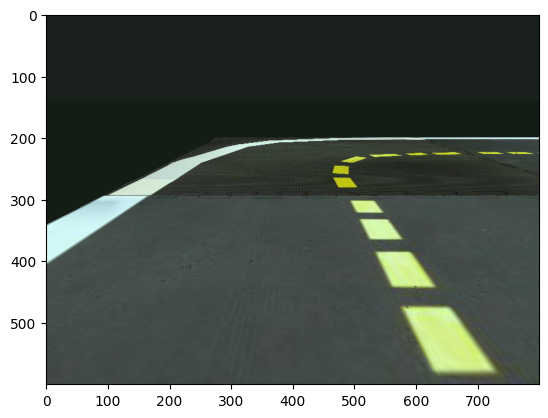

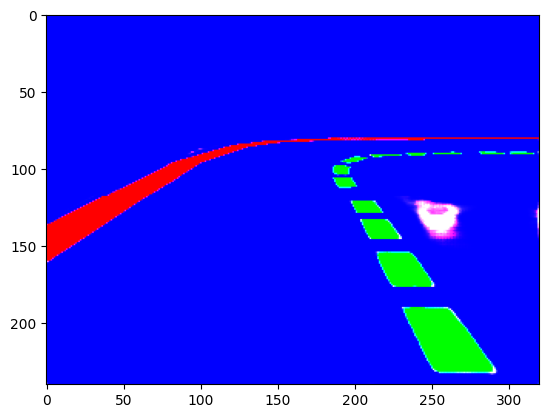

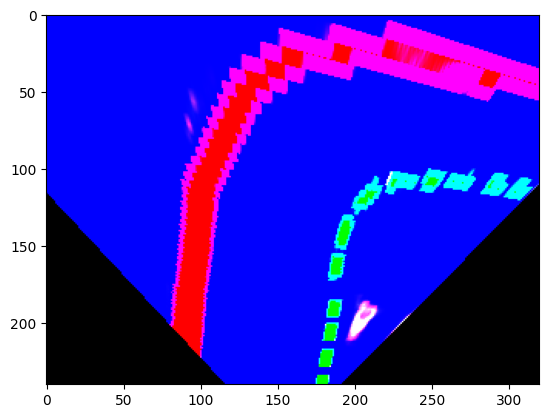

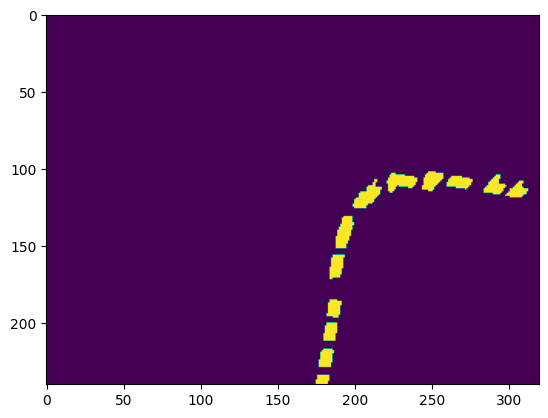

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


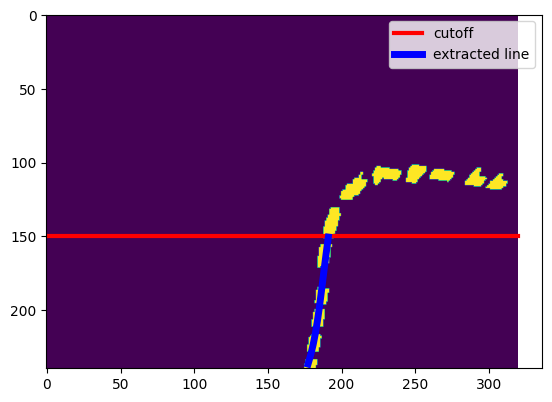

[[0.04592593 0.05089909 0.05521749 0.05901843 0.06243915 0.06561696
  0.06868911 0.07179288 0.07506554 0.07864438 0.08266667]
 [0.64888889 0.66610986 0.68431742 0.70362134 0.72413137 0.74595728
  0.76920883 0.79399578 0.8204279  0.84861494 0.87866667]]


/usr/local/lib/python3.9/dist-packages/geometry/poses.py:274: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  linear = np.array(linear, dtype='float64')
/usr/local/lib/python3.9/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


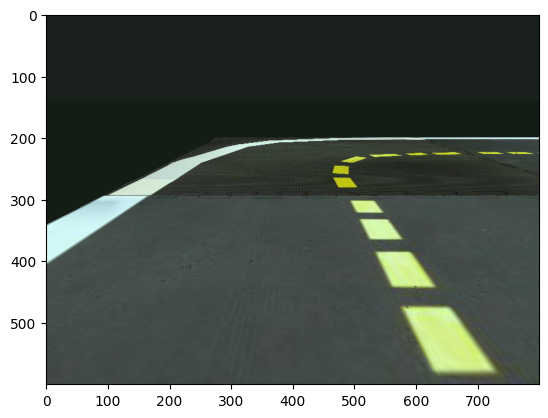

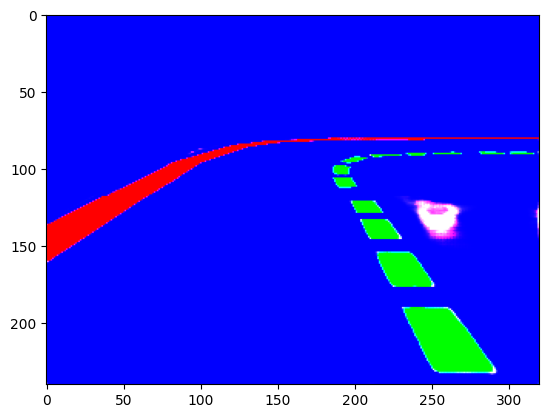

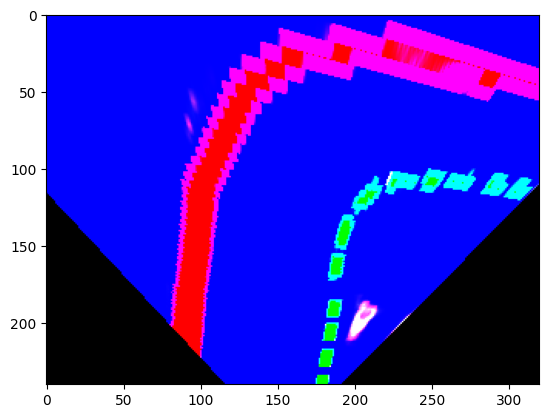

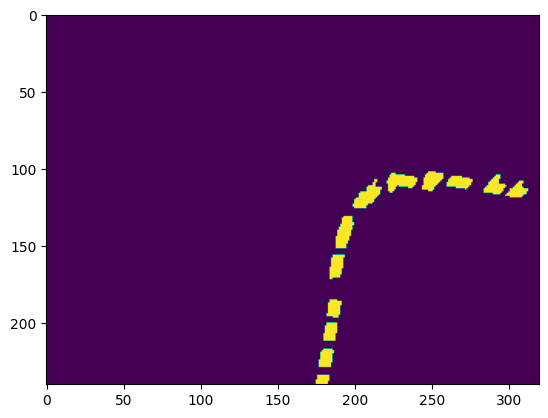

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


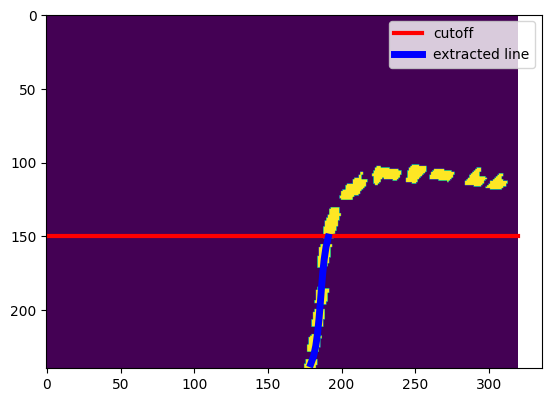

[[0.05088435 0.05599169 0.06002106 0.06321594 0.06581981 0.06807615
  0.07022844 0.07252016 0.07519478 0.07849579 0.08266667]
 [0.64930612 0.6631122  0.6821396  0.70519114 0.73106967 0.75857804
  0.78651907 0.81369561 0.8389105  0.86096657 0.87866667]]


/usr/local/lib/python3.9/dist-packages/geometry/poses.py:274: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  linear = np.array(linear, dtype='float64')
/usr/local/lib/python3.9/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


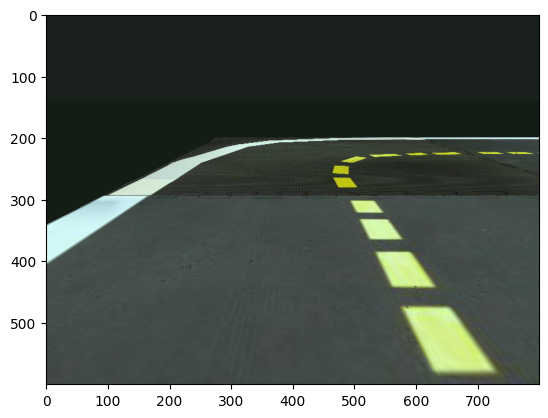

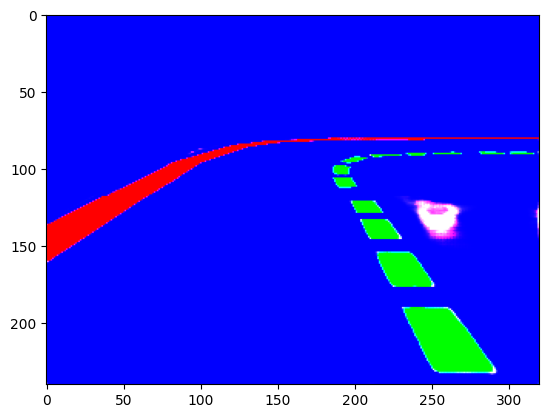

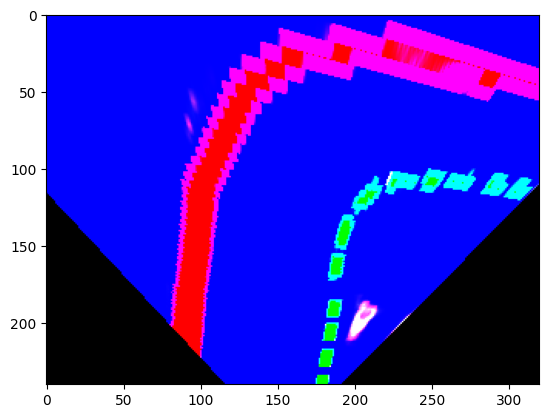

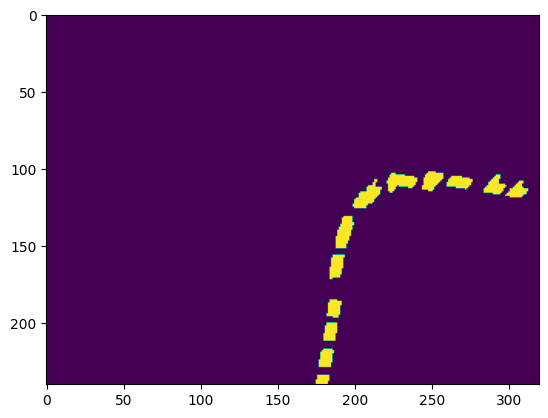

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


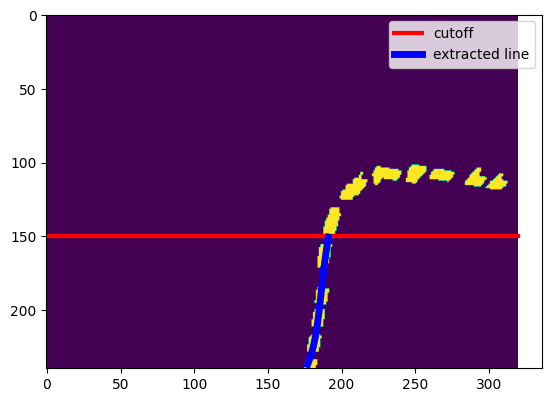

[[0.04533333 0.05120381 0.05593497 0.05977596 0.06297594 0.06578404
  0.06844941 0.07122122 0.07434859 0.07808069 0.08266667]
 [0.64833333 0.66472507 0.68239221 0.70140995 0.72185347 0.74379797
  0.76731863 0.79249064 0.81938919 0.84808947 0.87866667]]


/usr/local/lib/python3.9/dist-packages/geometry/poses.py:274: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  linear = np.array(linear, dtype='float64')
/usr/local/lib/python3.9/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


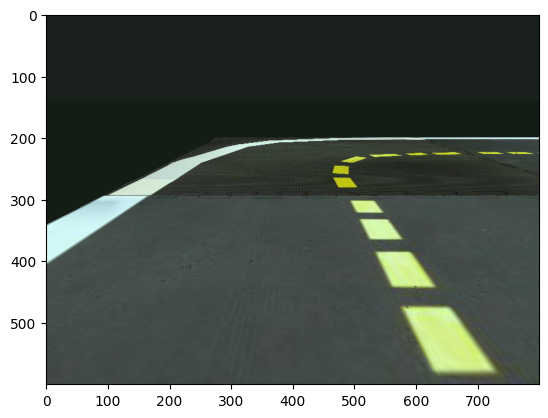

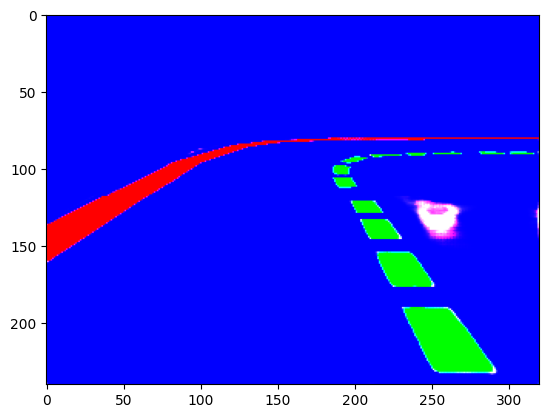

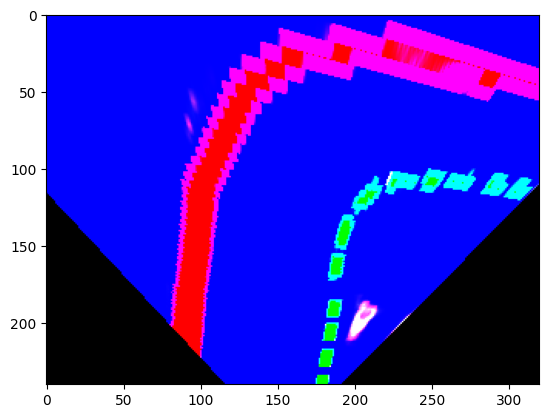

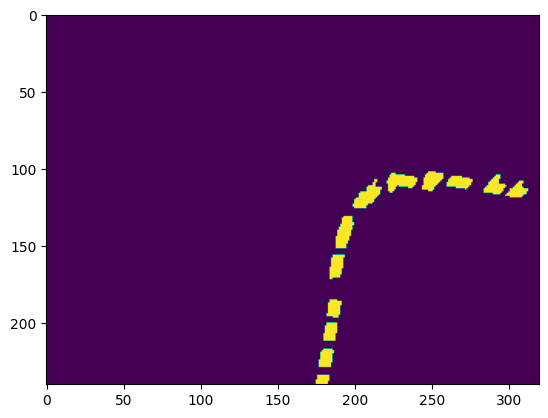

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


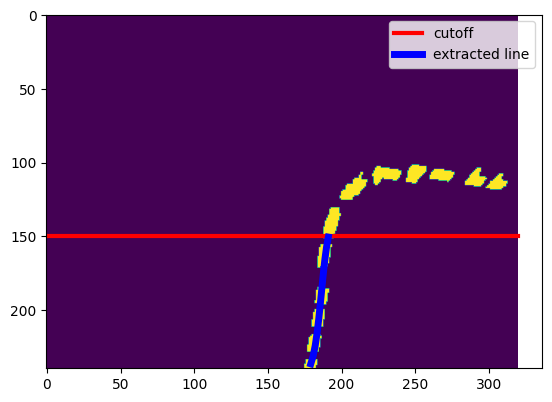

[[0.05088435 0.05518514 0.0589735  0.06234805 0.0654074  0.06825016
  0.07097495 0.07368038 0.07646507 0.07942763 0.08266667]
 [0.64930612 0.66343425 0.68260787 0.70566893 0.73145935 0.75882107
  0.78659601 0.81362611 0.83875329 0.8608195  0.87866667]]


/usr/local/lib/python3.9/dist-packages/geometry/poses.py:274: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  linear = np.array(linear, dtype='float64')
/usr/local/lib/python3.9/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


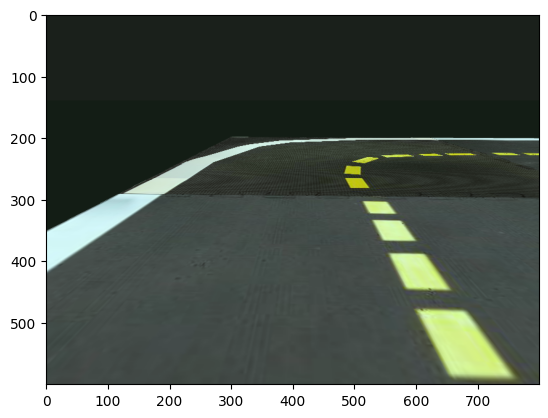

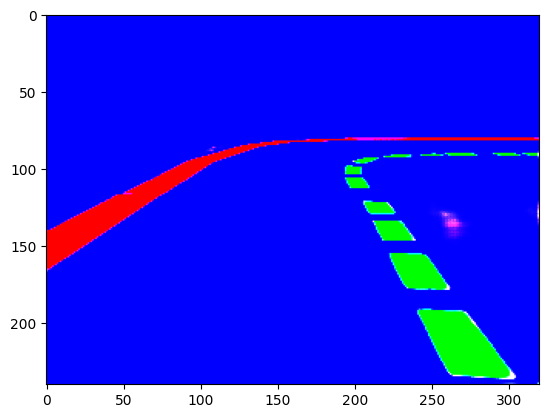

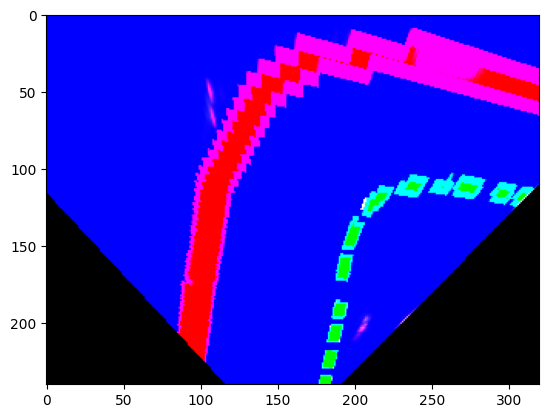

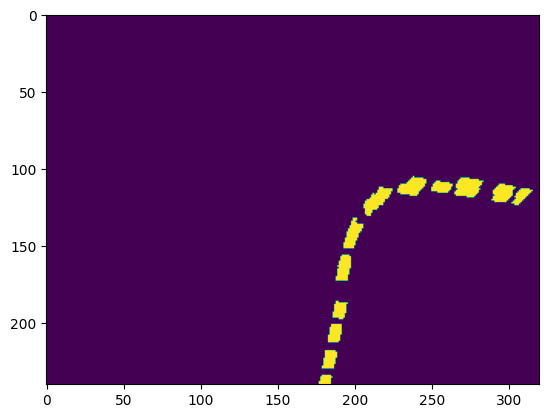

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


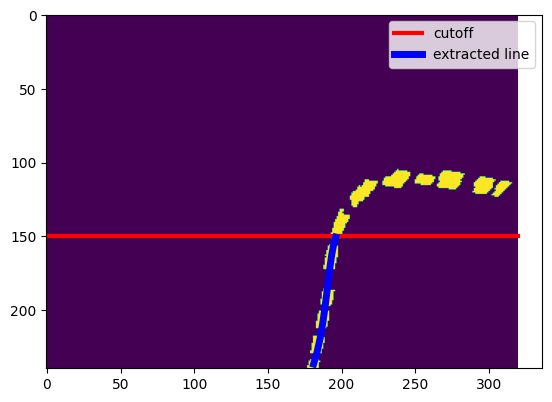

[[0.05593939 0.06238613 0.06779115 0.07234172 0.07622508 0.07962849
  0.0827392  0.08574445 0.0888315  0.0921876  0.096     ]
 [0.6490303  0.67112489 0.69564975 0.72176593 0.74863452 0.77541659
  0.80127321 0.82536545 0.8468544  0.86490111 0.87866667]]


/usr/local/lib/python3.9/dist-packages/geometry/poses.py:274: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  linear = np.array(linear, dtype='float64')
/usr/local/lib/python3.9/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


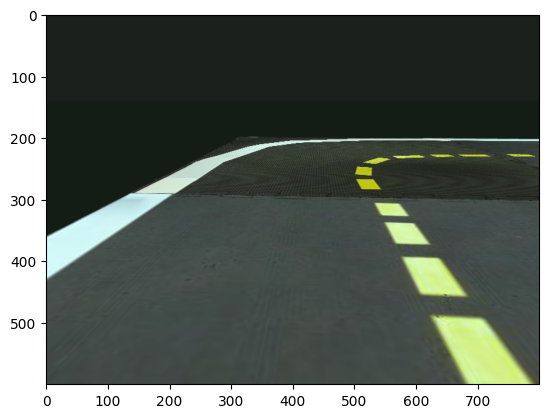

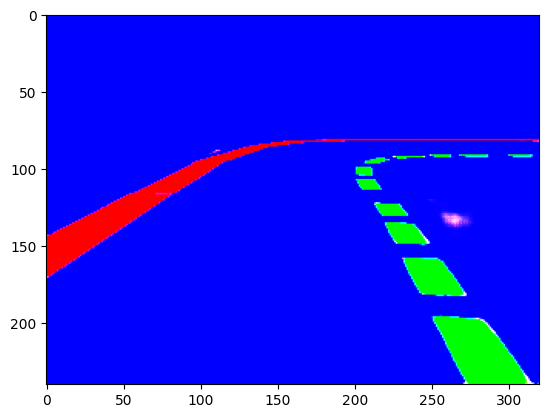

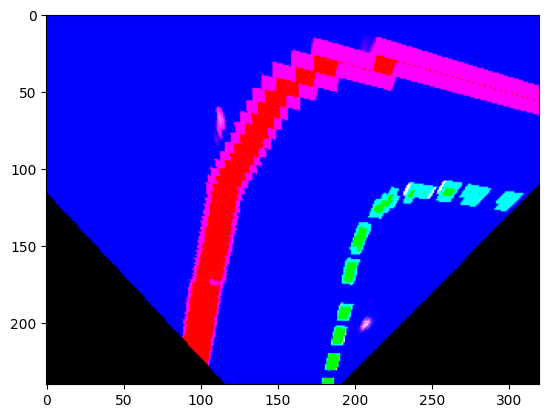

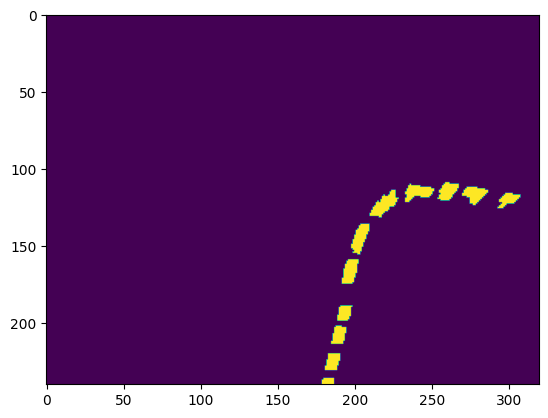

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


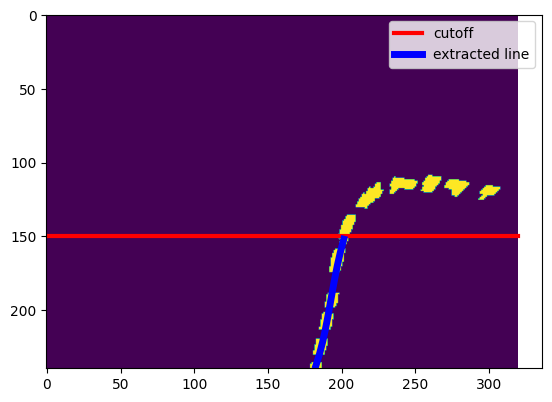

[[0.06030108 0.0667562  0.07228325 0.07711102 0.08146833 0.08558397
  0.08968675 0.09400549 0.09876898 0.10420603 0.11054545]
 [0.64653763 0.66740546 0.68880693 0.71070537 0.73306409 0.75584641
  0.77901566 0.80253515 0.8263682  0.85047814 0.87482828]]


/usr/local/lib/python3.9/dist-packages/geometry/poses.py:274: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  linear = np.array(linear, dtype='float64')
/usr/local/lib/python3.9/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


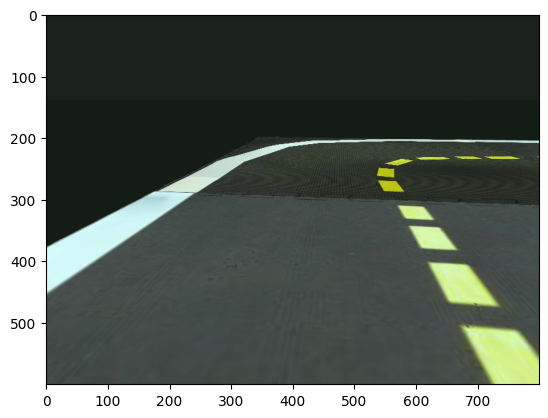

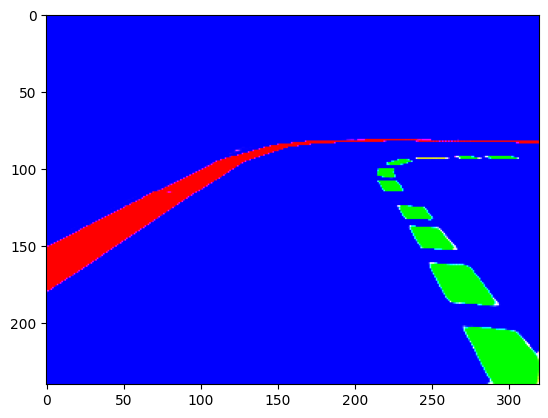

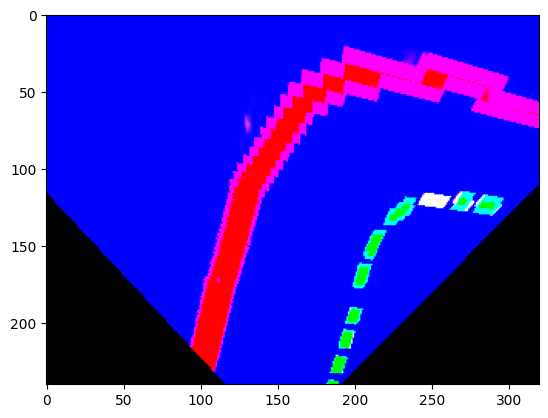

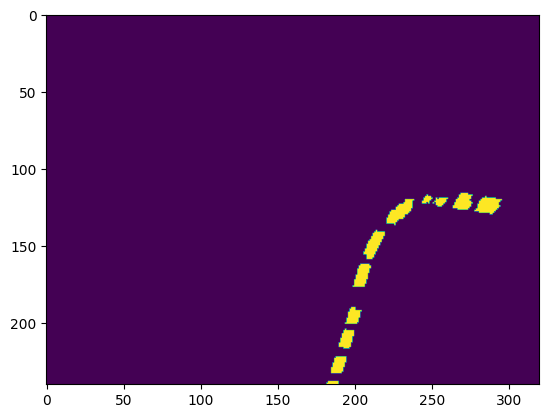

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


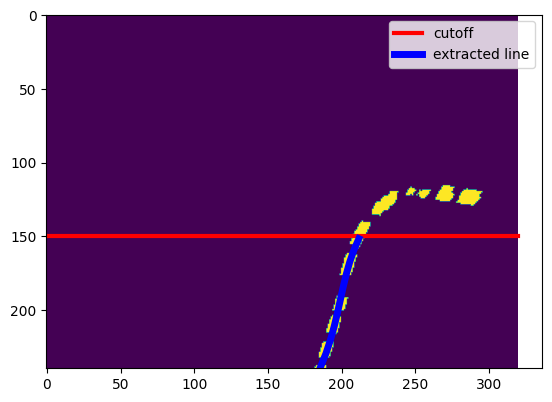

[[0.06862222 0.07854878 0.08666328 0.09339507 0.09917348 0.10442788
  0.1095876  0.11508199 0.1213404  0.12879218 0.13786667]
 [0.64391111 0.66866384 0.69326455 0.71763937 0.74171442 0.76541586
  0.7886698  0.81140238 0.83353975 0.85500802 0.87573333]]


/usr/local/lib/python3.9/dist-packages/geometry/poses.py:274: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  linear = np.array(linear, dtype='float64')
/usr/local/lib/python3.9/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


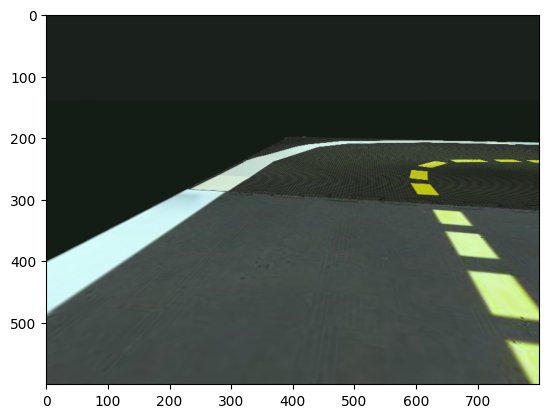

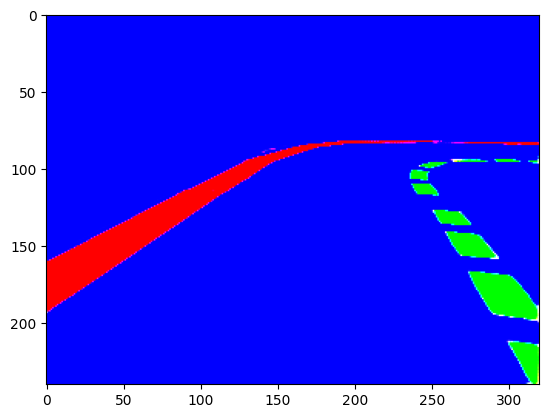

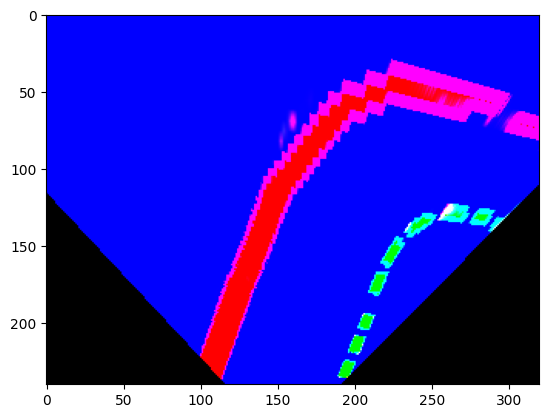

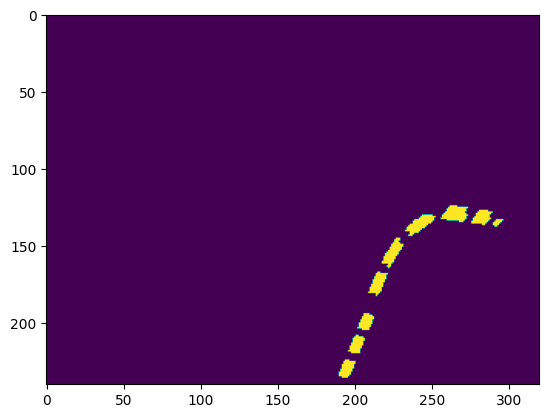

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


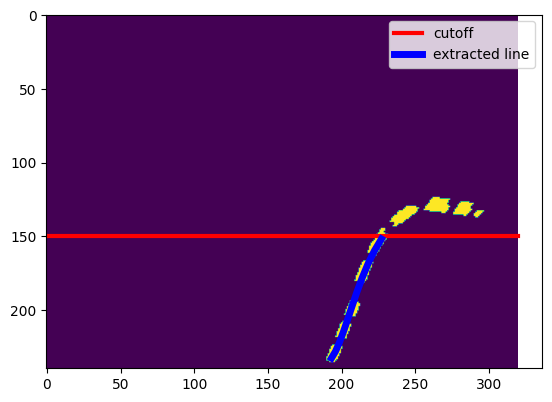

[[0.08830476 0.09557622 0.10280076 0.11014369 0.11777036 0.1258461
  0.13453625 0.14400612 0.15442106 0.1659464  0.17874747]
 [0.65973333 0.6718269  0.68815453 0.70791648 0.73031301 0.75454436
  0.77981079 0.80531255 0.83024989 0.85382307 0.87523232]]


/usr/local/lib/python3.9/dist-packages/geometry/poses.py:274: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  linear = np.array(linear, dtype='float64')
/usr/local/lib/python3.9/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


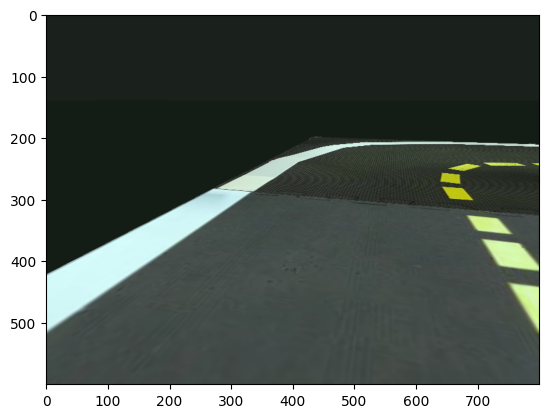

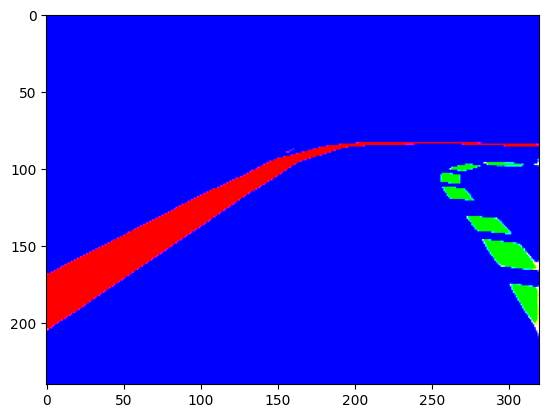

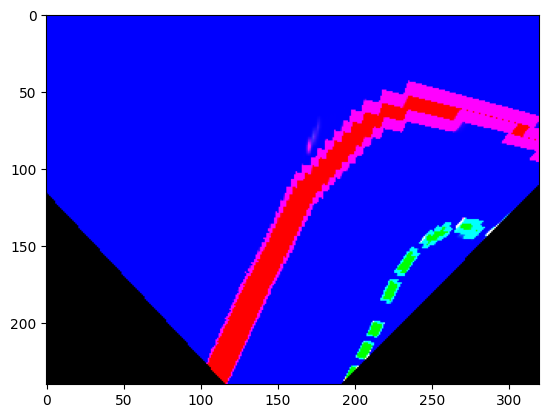

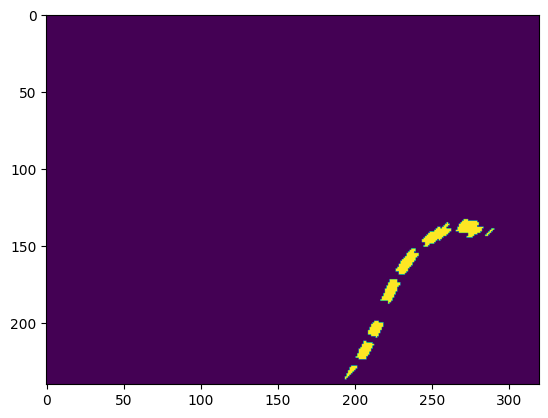

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


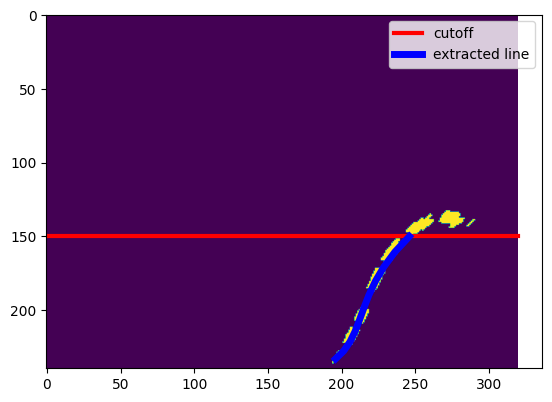

[[0.09558974 0.11053055 0.12192971 0.1309848  0.1388934  0.1468531
  0.15606147 0.16771609 0.18301456 0.20315444 0.22933333]
 [0.65825641 0.67277794 0.68938457 0.70793214 0.72827645 0.75027332
  0.77377859 0.79864807 0.82473759 0.85190296 0.88      ]]


/usr/local/lib/python3.9/dist-packages/geometry/poses.py:274: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  linear = np.array(linear, dtype='float64')
/usr/local/lib/python3.9/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


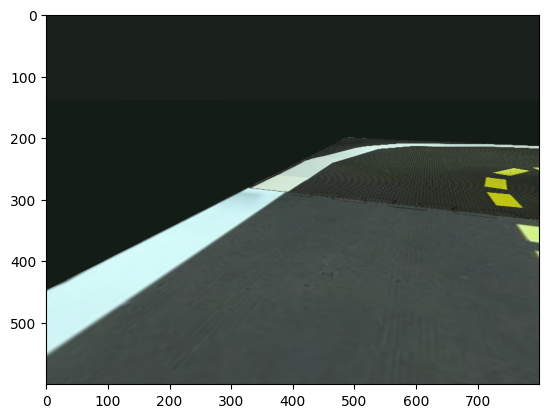

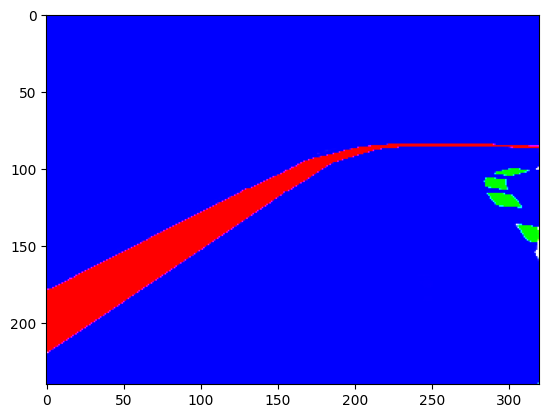

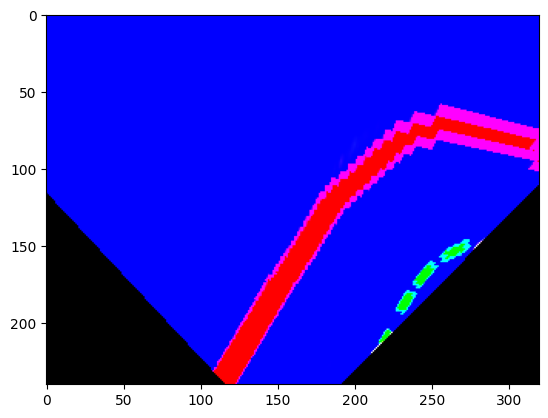

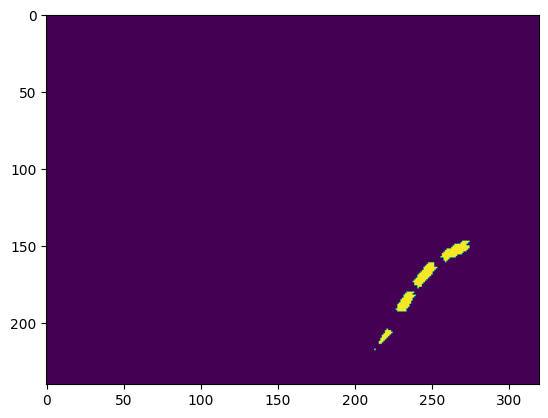

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


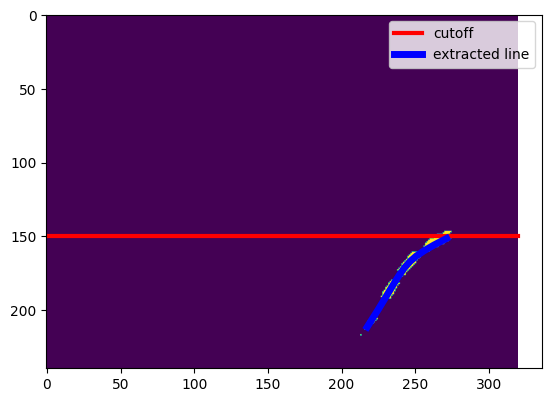

[[0.15295238 0.17299542 0.18858294 0.20091287 0.21118313 0.22059162
  0.23033628 0.24161503 0.25562577 0.27356643 0.29663492]
 [0.716      0.74776244 0.773401   0.79390124 0.81024872 0.82342901
  0.83442769 0.8442303  0.85382242 0.86418962 0.87631746]]


/usr/local/lib/python3.9/dist-packages/geometry/poses.py:274: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  linear = np.array(linear, dtype='float64')
/usr/local/lib/python3.9/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


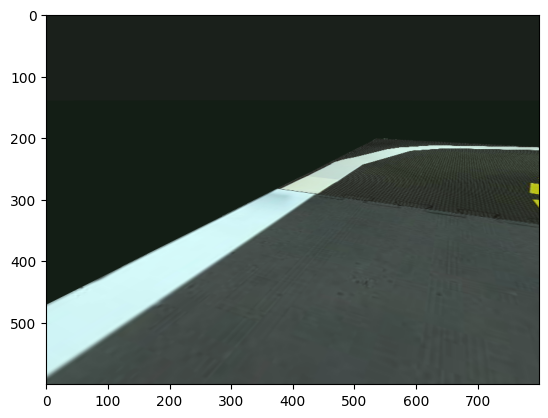

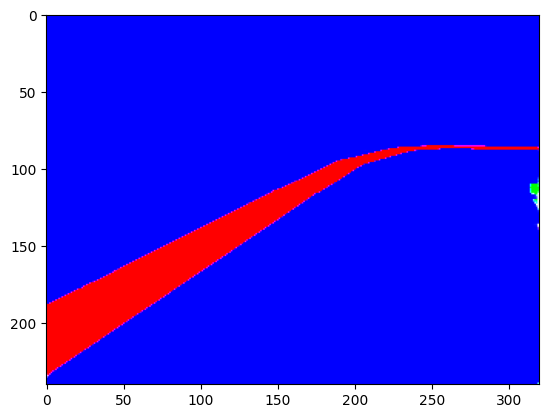

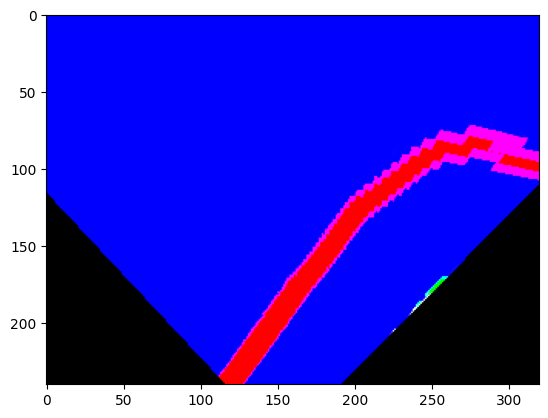

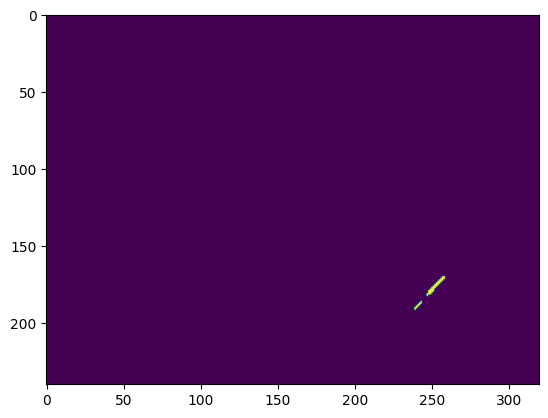

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


IndexError: ignored

In [12]:
from poliduckie_segmentation.model import Model
import casadi as ca

VERTICAL_CUTOFF = 150

# State X = [x, y, angle, longitudinal speed, angular speed]
state = ca.DM([0,0,0,0,0])

F = Model()

image_recording = []

for _ in range(100):
  image = env.render(mode="rgb_array")
  image_BGR = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  imshow(image)

  image_recording.append(image)
  image_segmentation = segmentation(image_BGR)[0]*255
  img_size_y = image_segmentation.shape[0]
  imshow(image_segmentation)

  image_birdeye = birdEyeTransform(image_segmentation)
  imshow(image_birdeye)

  dottedLineMask = cv2.threshold(image_birdeye[:, :, 1], 70, 255, cv2.THRESH_BINARY)[1]
  imshow(dottedLineMask)

  dottedLineMaskCropped = dottedLineMask[VERTICAL_CUTOFF:, :]

  line = lineExtraction(dottedLineMaskCropped, mode='bezier', n_points=N+1)
  plt.imshow(dottedLineMask)
  plt.plot([0, 320], [VERTICAL_CUTOFF, VERTICAL_CUTOFF], color='red', linewidth=3, label='cutoff')
  plt.plot(line[0], line[1] + VERTICAL_CUTOFF, color='blue', linewidth=5, label='extracted line')
  plt.legend()
  plt.show()

  reference = computeReference(line, N+1, VERTICAL_CUTOFF, img_size_y)
  print(reference)
  
  action = runMpc(state, reference)
  state = F.step(*state.toarray().reshape(-1), action)
  state = ca.DM([0,0,0,state[-2],state[-1]])
  env.step(action)